## 0. Imports

 0.1 Import core Python and plotting libraries plus the factor-model helpers; this cell wires the notebook into the existing systrat_factmod codebase and data folders.

 0.2 Define the base project path, DATA_INT directory, universe tickers, and date range so all later cells read from the same factor/alpha artifacts used in our CLI runs.

In [2]:
import sys
from pathlib import Path

# Project root (one level ABOVE src)
PROJ_ROOT = Path(r"C:\Users\quantbase\Desktop\SyStrat_factmod")

if str(PROJ_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJ_ROOT))

print("Project root on sys.path:", PROJ_ROOT in map(Path, map(str, sys.path)))

from src.fm_config import DATA_INT
print("DATA_INT =", DATA_INT)

Project root on sys.path: True
DATA_INT = C:\Users\quantbase\Desktop\SyStrat_factmod\data_int


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  1. Load core artifacts (factor model outputs) 

 1.1: Load factor returns and covariance:
    Load daily factor returns and the factor covariance matrix; this is the time-series view of how each style factor has actually been paying off historically.


 1.2: Load per-stock scores / alpha panel:
    Load the per-stock factor panel with SIZE, VAL, MOM, QUAL, technical factors, residual alpha, and risk estimates; this is the main table from which all rankings and sector breakdowns are derived.

In [4]:
# Factor model outputs
factor_returns_us = pd.read_parquet(DATA_INT / "factor_returns_us.parquet")
factor_cov_us     = pd.read_parquet(DATA_INT / "factor_cov_us.parquet")
factor_resid_us   = pd.read_parquet(DATA_INT / "factor_residuals_us.parquet")

# Style panel + alpha panel + scores
factor_panel_us   = pd.read_parquet(DATA_INT / "factor_panel_us.parquet")
style_us_full     = pd.read_parquet(DATA_INT / "style_us_full.parquet")
alpha_panel_us    = pd.read_parquet(DATA_INT / "alpha_panel_us.parquet")
scores_us         = pd.read_parquet(DATA_INT / "scores_us.parquet")

factor_returns_us.head(), factor_cov_us, scores_us.tail()

(              market  sector_Communication Services  \
 date                                                  
 2021-11-02  0.001730                       0.001861   
 2021-11-03  0.004885                       0.006107   
 2021-11-04  0.007573                       0.001382   
 2021-11-05  0.005470                      -0.002796   
 2021-11-08  0.003165                      -0.005304   
 
             sector_Consumer Discretionary  sector_Consumer Staples  \
 date                                                                 
 2021-11-02                      -0.006513                 0.003607   
 2021-11-03                       0.011467                 0.001578   
 2021-11-04                       0.009735                 0.000330   
 2021-11-05                      -0.004071                -0.004284   
 2021-11-08                      -0.011729                -0.013222   
 
             sector_Energy  sector_Financials  sector_Health Care  \
 date                                 

----------------------------------------------
## 2 Factor summary on latest date

 2.1: 
 Show snapshot head / selected columns:
    Restrict the scores table to the current working universe (e.g. top-50 S&P names) and a clean date window, so that all summaries are computed on the same cross-section.

 2.2: 
 Summary stats by factor:
    Take the latest available date and slice the scores table down to one row per stock; this gives the single-day cross-section on which we rank names and compute sector weights.

 2.3:
 Distributions:
    Factor returns distribution on latest date

In [5]:
last_date = scores_us["date"].max()
universe_today = scores_us.loc[scores_us["date"] == last_date].copy()

universe_today[["ticker", "sector", "S_long", "mu_factor", "alpha_resid", "sigma"]].sort_values(
    "S_long", ascending=False
).head(15)

,ticker,sector,S_long,mu_factor,alpha_resid,sigma
48944,NFLX,Communication Services,2.088306,0.010621,0.000056,0.020105
48931,ISRG,Health Care,1.720974,0.003529,0.001686,0.017337
48948,PG,Consumer Staples,1.634774,0.001536,0.001521,0.009690
48922,COST,Consumer Staples,1.603945,0.004207,0.000702,0.011448
48940,MRK,Health Care,1.603155,-0.003415,0.003385,0.011596
48914,ABT,Health Care,1.365981,-0.001113,0.002178,0.011413
48955,UNH,Health Care,1.343390,0.001369,0.001822,0.017223
48923,CRM,Information Technology,1.168979,0.004944,0.000290,0.017237
48958,WMT,Consumer Staples,1.166272,0.004187,-0.000108,0.010286
48930,IBM,Information Technology,1.077146,0.002665,0.000697,0.014671


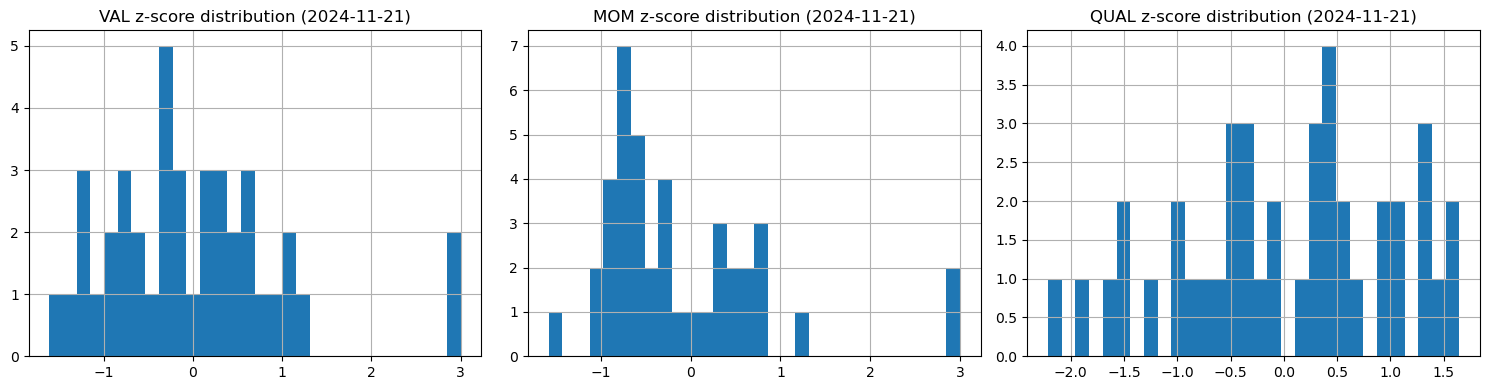

In [11]:
# factor Distributions


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ["VAL", "MOM", "QUAL"]):
    universe_today[col].hist(bins=30, ax=ax)
    ax.set_title(f"{col} z-score distribution ({last_date.date()})")

plt.tight_layout()


-------------------------
## 3. Factor returns plots (market + style factors)

 3.1: 
    Display a compact view of today’s cross-section with ticker, sector, composite score, and key style factors to sanity-check that the inputs match our mental model.

 3.2: 
    Compute basic statistics (mean, standard deviation, min/max) for each style factor on the latest date to show how strongly the universe is dispersed along each dimension.

 3.3:
    Calculate and inspect the cross-sectional correlation matrix of today’s style factors to evidence which signals are complementary versus redundant.

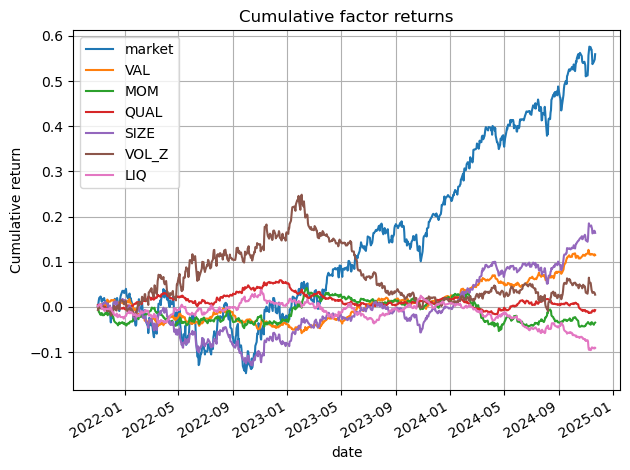

In [15]:
style_cols = ["VAL", "MOM", "QUAL", "SIZE", "VOL_Z", "LIQ"]

fac_ret = factor_returns_us.copy()
fac_ret = fac_ret.sort_index()

cum_fac = (1 + fac_ret[["market"] + style_cols]).cumprod() - 1

ax = cum_fac.plot()
ax.set_title("Cumulative factor returns")
ax.set_ylabel("Cumulative return")
ax.grid(True)
plt.tight_layout()


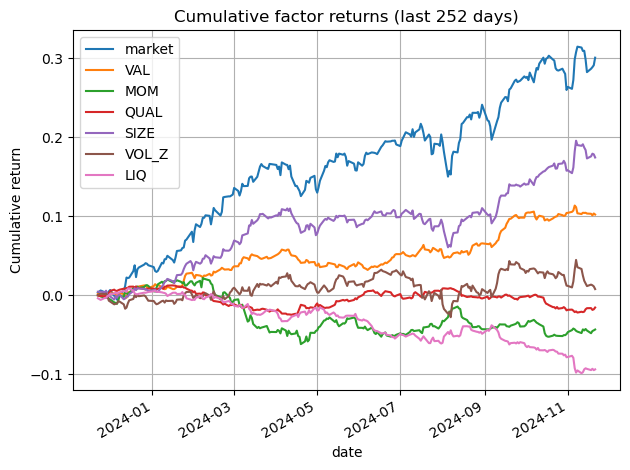

In [13]:
# Specific Window Cumulative Factor Returns

window = 252  # trading days
fac_window = fac_ret.iloc[-window:]
cum_window = (1 + fac_window[["market"] + style_cols]).cumprod() - 1

ax = cum_window.plot()
ax.set_title(f"Cumulative factor returns (last {window} days)")
ax.set_ylabel("Cumulative return")
ax.grid(True)
plt.tight_layout()

-----------------------
## 4. Sector breakdown of the current long basket
 4.1: 
    Display a compact view of today’s cross-section with ticker, sector, composite score, and key style factors to sanity-check that the inputs match our mental model.

 4.2:
    Compute basic statistics (mean, standard deviation, min/max) for each style factor on the latest date to show how strongly the universe is dispersed along each dimension.

 4.3: 
    Calculate and inspect the cross-sectional correlation matrix of today’s style factors to evidence which signals are complementary versus redundant.

In [ ]:
N_LONG = 10

longs_latest = (
    universe_today
    .sort_values("S_long", ascending=False)
    .head(N_LONG)
    .copy()
)

longs_latest[["ticker", "sector", "S_long"]]

,ticker,sector,S_long
48944,NFLX,Communication Services,2.088306
48931,ISRG,Health Care,1.720974
48948,PG,Consumer Staples,1.634774
48922,COST,Consumer Staples,1.603945
48940,MRK,Health Care,1.603155
48914,ABT,Health Care,1.365981
48955,UNH,Health Care,1.343390
48923,CRM,Information Technology,1.168979
48958,WMT,Consumer Staples,1.166272
48930,IBM,Information Technology,1.077146


,model_weight
sector,
Health Care,6.033499
Consumer Staples,4.404991
Information Technology,2.246125
Communication Services,2.088306


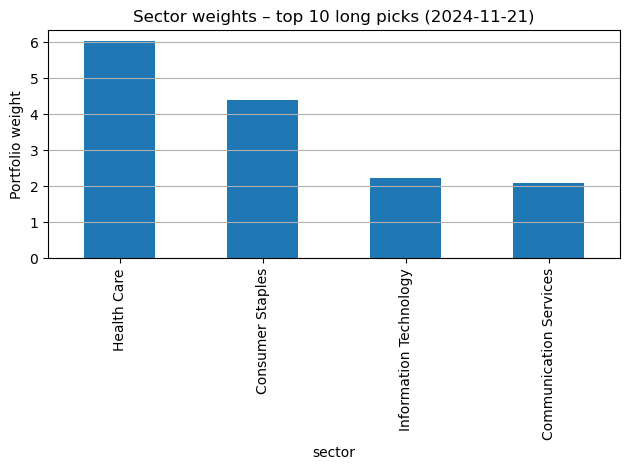

In [21]:
# Sector weights

sector_weights = (
    longs_latest
    .groupby("sector")["S_long"]
    .sum()
    .sort_values(ascending=False)
)

ax = sector_weights.plot(kind="bar")
ax.set_title(f"Sector weights – top {N_LONG} long picks ({last_date.date()})")
ax.set_ylabel("Portfolio weight")
ax.grid(axis="y")
plt.tight_layout()

sector_weights.to_frame("model_weight")

-----------------------
## 5. Factor profile by sector (weighted averages)
 5.1: 
    Aggregate current portfolio weights by sector to obtain the sector weight profile implied by the factor scores and ranking logic.

 5.2:
    Join our portfolio sector weights to benchmark (e.g. S&P 500) sector weights to quantify where the factor process is systematically overweight or underweight.

In [ ]:
factor_cols_for_profile = ["SIZE", "VAL", "MOM", "QUAL"]

sector_factor_profile = (
    longs_latest
    .groupby("sector")
    .apply(
        lambda g: (g[factor_cols_for_profile]
                   .mul(g["S_long"], axis=0)
                   .sum()
                   / g["S_long"].sum())
    )
    .sort_index()
)

sector_factor_profile


C:\Users\quantbase\AppData\Local\Temp\ipykernel_17144\1220995259.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,SIZE,VAL,MOM,QUAL
sector,,,,
Communication Services,-0.022729,-0.908427,0.748138,-0.952108
Consumer Staples,0.229666,-0.251560,0.045644,-0.943788
Health Care,-0.440860,-0.068801,-0.424895,-0.181351
Information Technology,-0.470407,-0.009373,-0.031898,0.465028


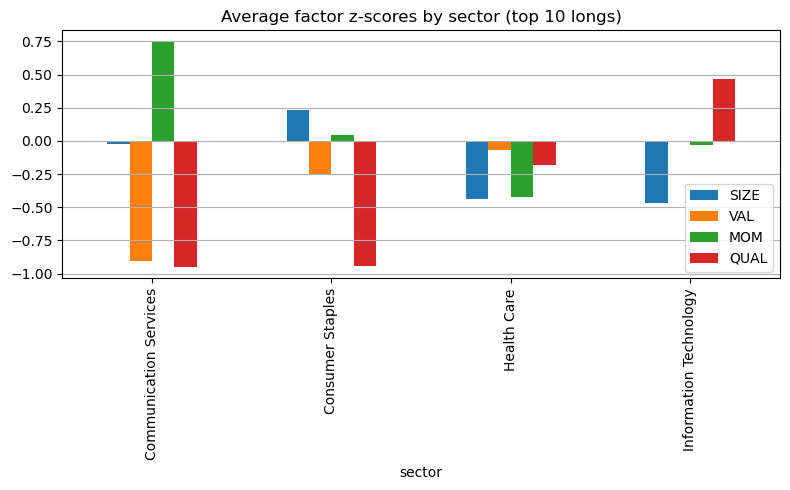

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
sector_factor_profile.plot(kind="bar", ax=ax)
ax.set_title(f"Average factor z-scores by sector (top {N_LONG} longs)")
ax.grid(axis="y")
plt.tight_layout()


In [ ]:
#----------------------------------------------------------------------------------